In [1]:
# 导入相应的库
import keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import itertools
import os

In [2]:
# 初始设置
im_height = 224 
im_width = 224
batch_size = 32
epochs = 15

image_path = 'G:/dataset/panicle_period/'
train_dir = image_path + "train"
val_dir = image_path + "val"
test_dir = image_path + "test"

In [3]:
# 数据预处理
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           rotation_range = 20,
                                           brightness_range = (1.2, 1.5),
                                           horizontal_flip=True
                                          )
val_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

In [4]:
# 生成数据
train_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(im_height, im_width),
                                                           class_mode='categorical')
total_train = train_data_gen.n

val_data_gen = val_image_generator.flow_from_directory( directory=val_dir,
                                                          batch_size=batch_size,
                                                          shuffle=False,
                                                          target_size=(im_height, im_width),
                                                          class_mode='categorical')
total_val = val_data_gen.n

test_data_gen = test_image_generator.flow_from_directory( directory=test_dir,
                                                          batch_size=batch_size,
                                                          shuffle=False,
                                                          target_size=(im_height, im_width),
                                                          class_mode='categorical')
total_test = test_data_gen.n

Found 39688 images belonging to 3 classes.
Found 13231 images belonging to 3 classes.
Found 13231 images belonging to 3 classes.


In [5]:
# weight_for_0 = (1 / 1341)*(total_train)/2.0 
# weight_for_1 = (1 / 3875)*(total_train)/2.0

# class_weight = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [6]:
# 构建模型
covn_base = tf.keras.applications.VGG16(weights='imagenet', include_top = False,
                                              input_shape=(im_height,im_width,3))
covn_base.trainable = False

model = tf.keras.Sequential()
model.add(covn_base)
# model.add(tf.keras.layers.GlobalAveragePooling2D()) #GAP层
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 75267     
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
# 编译模型
model.compile(
    optimizer = Adam(lr=0.0001),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
# try:
#     model.load_weights("./save_weights/DenseNet201.ckpt")
#     print("载入模型成果！继续训练模型")
# except :    
#     print("载入模型失败！开始训练一个新模型")

In [9]:
# 开始训练
# 监视’val_loss’的变化，如果两个轮次不变学习率衰减为原来的1/10
reduce_lr = ReduceLROnPlateau(
                                monitor='val_loss', 
                                factor=0.1, 
                                patience=2, 
                                mode='auto',
                                verbose=1
                             )

# 设置模型保存路径，且根据val_acc保存最优模型
checkpoint = ModelCheckpoint(
                                filepath='./save_weights/DenseNet201.ckpt',
                                monitor='val_acc', 
                                save_weights_only=False, 
                                save_best_only=True, 
                                mode='auto',
                                period=5
                            )

history = model.fit(x=train_data_gen,
                    steps_per_epoch=total_train // batch_size,
                    epochs=epochs,
                    validation_data=val_data_gen,
                    validation_steps=total_val // batch_size,
#                     class_weight=class_weight,
                    callbacks=[checkpoint, reduce_lr])

Epoch 1/15
 162/1240 [==>...........................] - ETA: 7:37 - loss: 0.6921 - accuracy: 0.6869

KeyboardInterrupt: 

[[1548  336  137]
 [ 445 3293 1011]
 [  67  238 6156]]


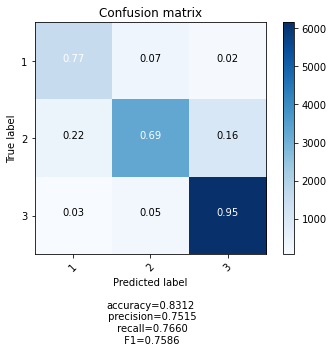

In [21]:
# 绘制混淆矩阵
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    print(cm)
    accuracy = np.trace(cm) / float(np.sum(cm)) #计算准确率
#     misclass = 1 - accuracy #计算错误率
    precision = cm[0][0]/cm.sum(axis=0)[0]
    recall = cm[0][0]/cm.sum(axis=1)[0]
    f1 = 2*precision*recall/(precision + recall)
    if cmap is None:
        cmap = plt.get_cmap('Blues') #颜色设置成蓝色
    plt.figure(figsize=(5, 4)) #设置窗口尺寸
    plt.imshow(cm, interpolation='nearest', cmap=cmap) #显示图片
    plt.title(title) #显示标题
    plt.colorbar() #绘制颜色条

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45) #x坐标标签旋转45度
        plt.yticks(tick_marks, target_names) #y坐标

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2) #对数字保留两位小数

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    #将cm.shape[0]、cm.shape[1]中的元素组成元组，遍历元组中每一个数字
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): 
        if normalize: #标准化
            plt.text(j, i, "{:0.2f}".format(cm[i, j]), #保留两位小数
                     horizontalalignment="center",  #数字在方框中间
                     color="white" if cm[i, j] > thresh else "black")  #设置字体颜色
        else:  #非标准化
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",  #数字在方框中间
                     color="white" if cm[i, j] > thresh else "black") #设置字体颜色

    plt.tight_layout() #自动调整子图参数,使之填充整个图像区域
    plt.ylabel('True label') #y方向上的标签
    #x方向上的标签
    plt.xlabel("Predicted label\n\naccuracy={:0.4f}\n precision={:0.4f}\n recall={:0.4f}\n F1={:0.4f}"
               .format(accuracy, precision, recall, f1))
#     plt.savefig("cm_cnn.png")
    plt.show() #显示图片
labels = ['1','2','3']

# 预测验证集数据整体准确率
Y_pred = model.predict_generator(test_data_gen, total_test // batch_size + 1)
# 将预测的结果转化为one hit向量
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# 计算混淆矩阵
confusion_mtx = confusion_matrix(y_true = test_data_gen.classes,y_pred = Y_pred_classes)
# 绘制混淆矩阵
plot_confusion_matrix(confusion_mtx, normalize=True, target_names=labels)

In [16]:
# 遍历验证集的图片
val_dir = image_path + "val/"
normal_dirs = os.listdir(val_dir+'NORMAL')
pneumonia_dirs = os.listdir(val_dir+'PNEUMONIA')
img_path1 = []
num=0
for i in normal_dirs:                             
    if os.path.splitext(i)[1] == ".jpeg":   
        img_path1.append(val_dir+"NORMAL/"+ i)
        num+=1
    if(num>=12):
        break
for i in pneumonia_dirs:                             
    if os.path.splitext(i)[1] == ".jpeg":   
        img_path1.append(val_dir+"PNEUMONIA/"+i)
        num+=1
    if(num>=12):
        break
# print(img_path1)

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'G:/dataset/panicle_period/val/NORMAL'

In [15]:
# 测试模型
#获取数据集的类别编码
class_indices = train_data_gen.class_indices 
#将编码和对应的类别存入字典
inverse_dict = dict((val, key) for key, val in class_indices.items()) 
fig = plt.figure(figsize=(15,12))
a=1
#加载测试图片
for i in img_path1:
    img = Image.open(i)
    # 将图片resize到224x224大小
    img = img.resize((im_width, im_height))
    #将灰度图转化为RGB模式
    img = img.convert("RGB")
    # 归一化
    img1 = np.array(img) / 255.
    # 将图片增加一个维度，目的是匹配网络模型
    img1 = (np.expand_dims(img1, 0))
    #将预测结果转化为概率值
    result = np.squeeze(model.predict(img1))
    predict_class = np.argmax(result)
    #print(inverse_dict[int(predict_class)],result[predict_class])
    plt.subplot(3,4,a)
    a+=1
    #将预测的结果打印在图片上面
    plt.title([inverse_dict[int(predict_class)],result[predict_class]])
    #显示图片
    plt.imshow(img)
plt.show()

NameError: name 'img_path1' is not defined

<Figure size 1080x864 with 0 Axes>